# VGG19 classfication

### **Step 1**: Helping Hand

- Import necessary library
  - These library contains helpful and necessary functions for various parts

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

### **Step 2**: Data Mania

- Set directory to dataset
- Get all the images in the folder
  - We get the image path and label for each images while skipping masks and feed them to split
- Split train and test
  - The ratio we chose for this is 9 to 1 for train to test
- Set integer value for labels and map them
- Transform and load the data into the loaders

In [ ]:
data_dir = 'Dataset_BUSI_with_GT'

image_paths = []
labels = []

for label in os.listdir(data_dir) :
    class_folder = os.path.join(data_dir, label)
    if os.path.isdir(class_folder) :
        for image in os.listdir(class_folder) :
            if 'mask' not in image :
                image_paths.append(os.path.join(class_folder, image))
                labels.append(label)

# Create a dataframe for splitting
data = pd.DataFrame({'filename': image_paths, 'label': labels})

label_mapping = {'benign': 0, 'malignant': 1, 'normal': 2}

x_train, x_test, y_train, y_test = train_test_split(
    data['filename'], data['label'], test_size=0.1, stratify=data['label'], random_state=42
)

y_train, y_test = y_train.map(label_mapping).astype(int), y_test.map(label_mapping).astype(int)

class ImageDataset(Dataset) :
    def __init__(self, image_path, labels, transform=None) :
        self.image_path = image_path
        self.labels = labels
        self.transform = transform

    def __len__(self) :
        return len(self.image_path)

    def __getitem__(self, idx) :
        img_path = self.image_path[idx]
        image = Image.open(img_path).convert('L')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = ImageDataset(image_path=x_train.tolist(), labels=y_train.tolist(), transform=transform)
test_dataset = ImageDataset(image_path=x_test.tolist(), labels=y_test.tolist(), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

### **Step 3**: The Model

- Load in the pre-trained model
  - In this case it's vgg-19 with default parameters
- Adjust the model for our use
  - The input layer is modified to accept our data, output layer to get the 3 classes
- Move to device
- Set loss function and optimizer

In [ ]:
model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
model.classifier[6] = nn.Linear(4096, 3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

lost_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

### **Step 4**: Training Montage

- Create training loop
  - Setup to loop for 50 without early stopping since this was trained overnight
  - We will see the plotted loss later
- Set up loss monitoring
- Save the model

In [ ]:
train_losses = []
train_accuracies = []

# Training loop
num_epochs = 50
print('Traning start -----')
for epoch in range(num_epochs) :
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = lost_func(outputs, labels.long())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

model.eval()
# save model
torch.save(model.state_dict(), 'vgg19_breast_cancer_model.pth')

### **Step 5**: It's Showtime

- Test the model and get accuracy
- Get f1 and confusion matrix
- Visualize loss, accuracy, and confusion matrix
  - We use these and f1 to evaluate performances

In [ ]:
correct = 0
total = 0

all_preds = []
all_labels = []

print('Testing start -----')
with torch.no_grad() :
    for images, labels in test_loader :
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        # Count correct predict
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

f1 = f1_score(all_labels, all_preds, average='weighted')  # use 'weighted' for multi-class
print(f'Weighted F1 Score: {f1:.4f}')
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='blue', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.grid()
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', color='orange', label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, num_epochs + 1))
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

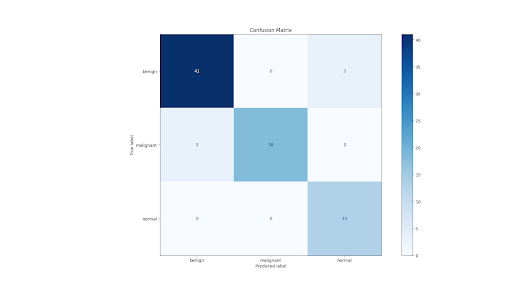

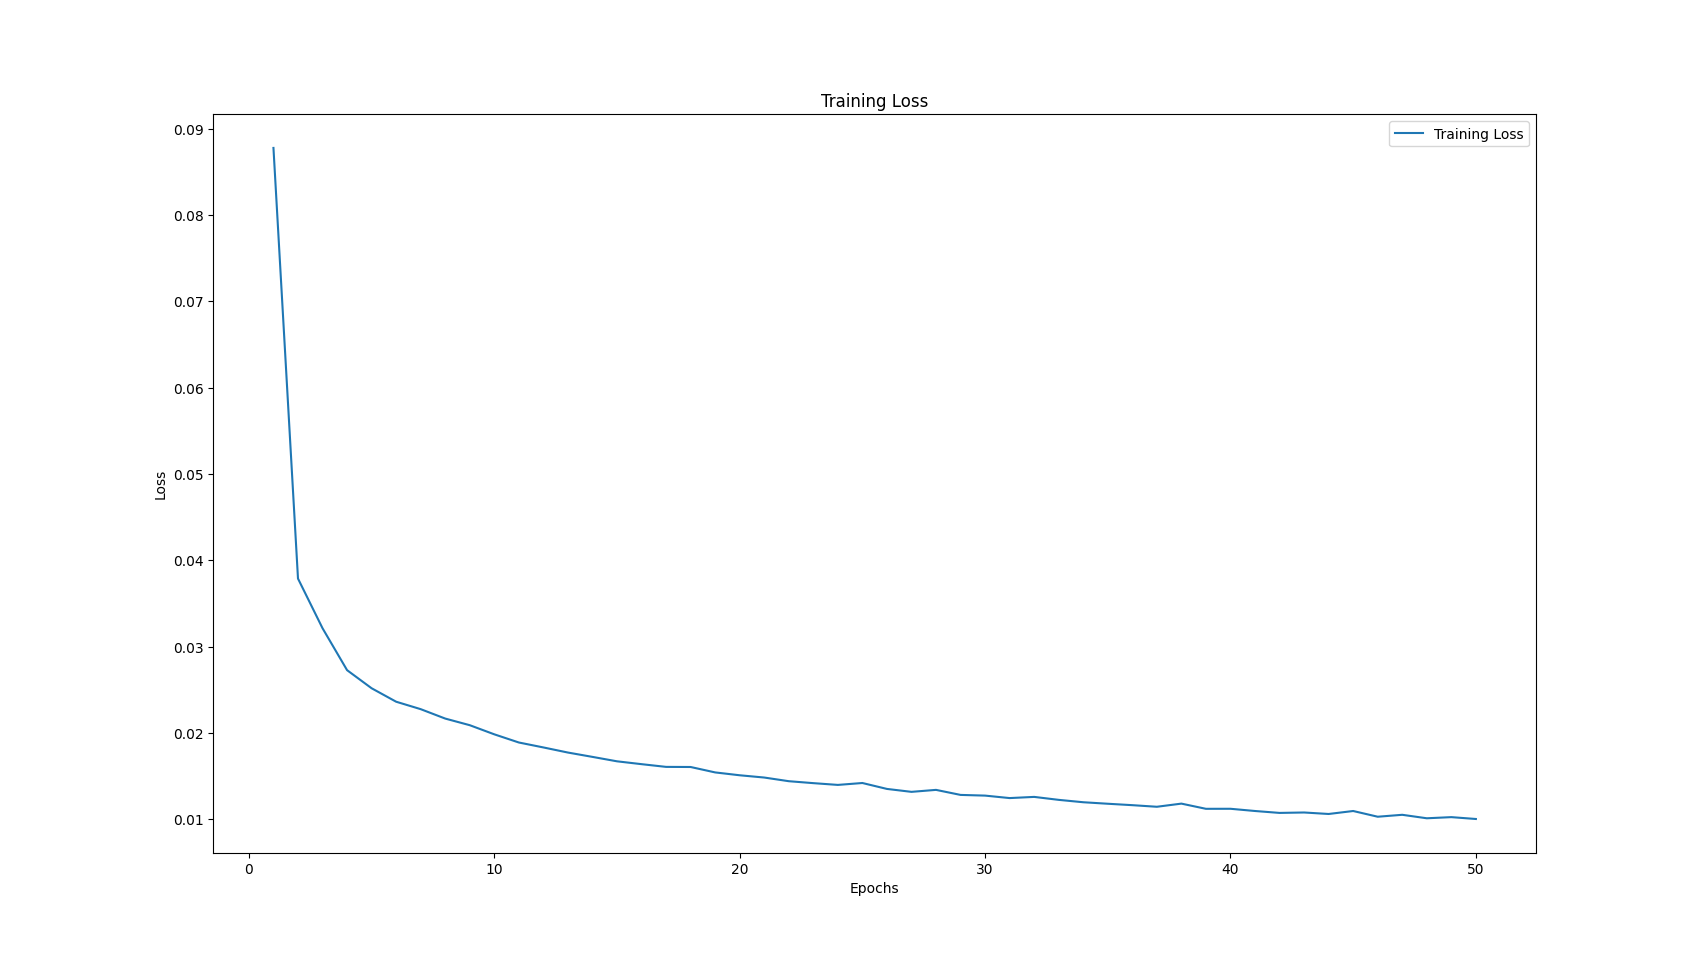